# Minimal Lasagne
The python script [load_mnist.py](load_mnist.py) contains functions to load the mnist data. The data is taken from http://deeplearning.net/data/mnist/mnist.pkl.gz. Basically the all images should be provided in a 4-dimensional array X with the following dimensions (number of images, number of colors, x, y) and the labels in a vector y of same size. So X[1,0,1,2] would be the image number 1, the color chanel 0 and the pixel x = 1 and y=2.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
from load_mnist import load_data_2d

Couldn't import dot_parser, loading of dot files will not be possible.


Using gpu device 1: GeForce GTX 780


In [2]:
X,y,PIXELS = load_data_2d('../../data/mnist.pkl.gz')

Loaded data
Shape of X (70000, 784)
  Min / Max X 0.0 0.996094
Shape of Y (70000,)
  Min / Max Y 0 9
After Batchnormalization Min / Max X / Mean -1.2488 / 66.487 / 8.03533e-10


X contains the images and y contains the labels.

In [3]:
X.shape

(70000, 1, 28, 28)

In [4]:
y.shape

(70000,)

##### Let s plot the first few images and label


In [5]:
y[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=int32)

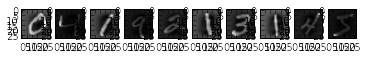

In [6]:
fig = plt.figure()
for i in range(10):
    a=fig.add_subplot(1,10,i)
    plt.imshow(X[i,0,:,:], cmap=plt.get_cmap('gray'))

### Our first Simple Network
Now since we have loaded our data. Let's train a network with it. First we load the necessary libraries and then simply build our network. 
#### Definition of the network

In [7]:
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import BatchIterator
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

net1 = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        ('conv1', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        ('conv2', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        ('hidden4', layers.DenseLayer),
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 1, PIXELS, PIXELS),
    conv1_num_filters=32, conv1_filter_size=(3, 3), pool1_ds=(2, 2),
    conv2_num_filters=64, conv2_filter_size=(2, 2), pool2_ds=(2, 2),
    hidden4_num_units=500,
    output_num_units=10, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=10,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

####Training of the net. 
Note that the data is split automatically into 80% Training and 20% Testset. We don't have to take care about this. Since it takes quite a while to finish an epoch (at least with a CPU), we reduce the data to 1000 samples (800 training and 200 testing).

In [8]:
net = net1.fit(X[0:1000,:,:,:],y[0:1000])

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    2.267661  |    2.140025  |     1.059643  |     41.96%  |  0.2s
     2  |    1.922303  |    1.718920  |     1.118320  |     48.13%  |  0.2s
     3  |    1.324206  |    1.086232  |     1.219082  |     69.86%  |  0.2s
     4  |    0.795069  |    0.772022  |     1.029853  |     74.98%  |  0.2s
     5  |    0.514836  |    0.675159  |     0.762540  |     82.05%  |  0.2

Note this takes a bit time on a CPU (approx 7 sec) for each epoch. If running on the GPU it onlty takes about 0.2 sec for each epoch.

##### Storing the trained model
We now have a trained model, which we can store using the pickle mechanism as follows

In [9]:
import cPickle as pickle
with open('data/net1.pickle', 'wb') as f:
    pickle.dump(net, f, -1)

In [10]:
%ls -rtlh data

total 13M
-rw-r--r-- 1 dueo dueo 13M Mar 26 01:26 net1.pickle


#### Loading a stored model
We load the model trained model again...

In [12]:
with open('data/net1.pickle', 'rb') as f:
    net_pretrain = pickle.load(f)

#### Training further (more iterations)
We can now take the net and train it for further iterations. We will see the the training loss is already quite low.

In [13]:
net_pretrain.fit(X[0:1000,:,:,:],y[0:1000]);

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.139824  |    0.546282  |     0.255955  |     85.32%  |  0.2s
     2  |    0.128598  |    0.547425  |     0.234915  |     85.59%  |  0.2s
     3  |    0.109014  |    0.546966  |     0.199307  |     85.86%  |  0.2s
     4  |    0.092420  |    0.543230  |     0.170130  |     86.25%  |  0.2s
     5  |    0.078050  |    0.547869  |     0.142461  |     86.25%  |  0.2

#### Training further (new data)
We can train also on new data and now on 5 epochs.

In [14]:
net_pretrain.max_epochs = 5
net_pretrain.fit(X[1000:2000,:,:,:],y[1000:2000]);

  InputLayer        	(None, 1, 28, 28)   	produces     784 outputs
  Conv2DLayer       	(None, 32, 26, 26)  	produces   21632 outputs
  MaxPool2DLayer    	(None, 32, 13, 13)  	produces    5408 outputs
  Conv2DLayer       	(None, 64, 12, 12)  	produces    9216 outputs
  MaxPool2DLayer    	(None, 64, 6, 6)    	produces    2304 outputs
  DenseLayer        	(None, 500)         	produces     500 outputs
  DenseLayer        	(None, 10)          	produces      10 outputs

 Epoch  |  Train loss  |  Valid loss  |  Train / Val  |  Valid acc  |  Dur
--------|--------------|--------------|---------------|-------------|-------
     1  |    0.692993  |    1.246727  |     0.555850  |     77.50%  |  0.2s
     2  |    0.318261  |    0.991479  |     0.320996  |     79.78%  |  0.2s
     3  |    0.221821  |    0.844999  |     0.262510  |     82.23%  |  0.2s
     4  |    0.141100  |    0.829447  |     0.170113  |     84.62%  |  0.2s
     5  |    0.103453  |    0.866650  |     0.119371  |     82.51%  |  0.2

### Evaluate the model
We now make predictions on unseen data. We have trained only on the images 0-1999.

In [15]:
preds = net_pretrain.predict(X[3000:3010,:,:,:])
preds, y[3000:3010]

(array([9, 0, 9, 8, 1, 3, 2, 5, 7, 4]),
 array([9, 0, 8, 8, 1, 3, 2, 5, 7, 4], dtype=int32))

Let's look at the correponding images.

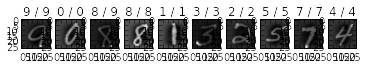

In [16]:
fig = plt.figure()
for i in range(10):
    a=fig.add_subplot(1,10,(i+1)) #NB the one based API sucks!
    a.set_title(str(y[(3000 + i)]) + " / " + str(preds[i]))
    plt.imshow(X[(3000+i),0,:,:], cmap=plt.get_cmap('gray'))